In [1]:
import sys
import os
sys.path.append(os.path.abspath('..'))  # or the full path to the "project" directory
import numpy as np
import gpbr

In [2]:
from gpbr.direct.common.boundary import Point2D
from gpbr.direct.common.distance import point_distance
def u2de(xp, t):
    point = Point2D(0,4)
    dist =point_distance(point, xp)
    return 1/4/np.pi/t*np.exp(-dist**2/4/t)
    

In [3]:
T = 1 # final time
N = 10 # N+1=10 time points
M = 16 # number of collocation points
ETA1= 0.5
ETA2= 2.0

In [4]:
from gpbr.direct.heat_equation.helpers import form_mfs_data
mfs_data = form_mfs_data(T,N,M)

In [5]:
def r1_func(vals):
    return np.ones(np.shape(vals))*0.8

def r2_func(vals):
    return np.ones(np.shape(vals))*1.6

In [6]:
from gpbr.direct.common.boundary import starlike_circle_base, starlike_curve
from gpbr.direct.common.collocation import collocation_points_2d
from gpbr.direct.common.source import source_points_2d
from gpbr.direct.heat_equation.helpers import form_boundary_data, form_mfs_data

coll_2d = collocation_points_2d(M, startpoint=False)
point_circle = starlike_circle_base(coll_2d)

Gamma1 = starlike_curve(r1_func(coll_2d.theta), point_circle)
Gamma2 = starlike_curve(r2_func(coll_2d.theta), point_circle)

source_coll_2d = collocation_points_2d(M//2, startpoint=False)
source_point_circle = starlike_circle_base(source_coll_2d)
Gamma1_source = starlike_curve(r1_func(source_coll_2d.theta), source_point_circle)
Gamma2_source = starlike_curve(r2_func(source_coll_2d.theta), source_point_circle)
source_points = source_points_2d(ETA1, ETA2, Gamma1_source, Gamma2_source)


In [7]:
import matplotlib.pyplot as plt

from gpbr.direct.common.boundary import StarlikeCurve
from gpbr.direct.common.source import SourcePoints2D

def plot_2d(G1: StarlikeCurve, G2: StarlikeCurve, source: SourcePoints2D):
    fig_plot, ax_plot = plt.subplots()
    g1_x, g1_y = G1.raw_points()
    g2_x, g2_y = G2.raw_points()
    ax_plot.plot(g1_x, g1_y, 'b--')
    ax_plot.plot(g2_x, g2_y, 'r--')

    for p in source_points:
        ax_plot.plot(p.x, p.y, 'bo')

    

    ax_plot.axis('equal')
    plt.grid()
    plt.show()
    plt.close()

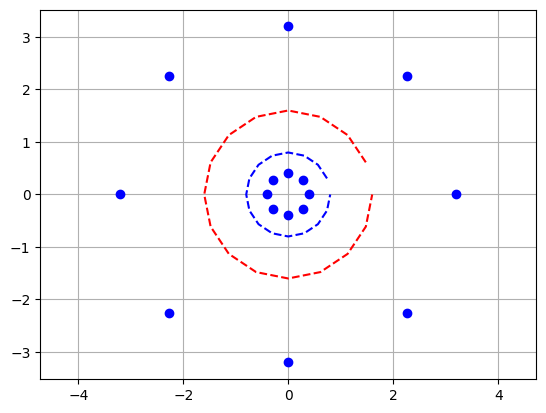

In [8]:
plot_2d(Gamma1, Gamma2, source_points)

# Approximation

In [9]:
from gpbr.direct.heat_equation.polynomial import MFSPolinomials2D, calculate_2d_polinomials

mfs_polynomyals = calculate_2d_polinomials(mfs_data)

In [10]:
from gpbr.direct.heat_equation.fundamental_sequence import fundamental_sequence_2d, FundamentalSequence

fundamental_sequence_gamma1 = fundamental_sequence_2d(Gamma1, source_points, mfs_data, mfs_polynomyals)
fundamental_sequence_gamma2 = fundamental_sequence_2d(Gamma2, source_points, mfs_data, mfs_polynomyals)

In [11]:
from gpbr.direct.common.boundary import Point2D, Point3D
from gpbr.direct.common.distance import point_distance


def f1(x: Point2D | Point3D , t):
    return u2de(x, t)

def f2(x: Point2D | Point3D, t: float) -> np.array:
    return u2de(x, t)

In [12]:
from gpbr.direct.heat_equation.helpers import form_fs_matrix, form_fs_vector_2d
PHI_MAT = form_fs_matrix(fundamental_sequence_gamma1, fundamental_sequence_gamma2)
PHI_MAT.shape

(32, 16)

In [13]:
PHI_MAT

array([[3.23010230e-06, 2.73551713e-07, 1.52446781e-08, 2.58827313e-09,
        2.58827313e-09, 1.52446781e-08, 2.73551713e-07, 3.23010230e-06,
        9.56681371e-02, 1.97206881e-02, 4.62463023e-03, 2.06453154e-03,
        2.06453154e-03, 4.62463023e-03, 1.97206881e-02, 9.56681371e-02],
       [4.77387264e-06, 1.13397585e-06, 6.03684693e-08, 5.15584128e-09,
        2.04417089e-09, 5.15584128e-09, 6.03684693e-08, 1.13397585e-06,
        1.32712453e-01, 4.56599531e-02, 8.97493161e-03, 2.81006458e-03,
        1.86004541e-03, 2.81006458e-03, 8.97493161e-03, 4.56599531e-02],
       [3.23010230e-06, 3.23010230e-06, 2.73551713e-07, 1.52446781e-08,
        2.58827313e-09, 2.58827313e-09, 1.52446781e-08, 2.73551713e-07,
        9.56681371e-02, 9.56681371e-02, 1.97206881e-02, 4.62463023e-03,
        2.06453154e-03, 2.06453154e-03, 4.62463023e-03, 1.97206881e-02],
       [1.13397585e-06, 4.77387264e-06, 1.13397585e-06, 6.03684693e-08,
        5.15584128e-09, 2.04417089e-09, 5.15584128e-09, 6.036

In [14]:
from gpbr.direct.heat_equation.fundamental_sequence import FundamentalSequenceCoefs

alpha_coeeff = np.empty((N+1, M), dtype=np.float64)
alpha_coeeff[:] = np.nan
fs_coefs = FundamentalSequenceCoefs(alpha_coeeff)

In [15]:
from numpy.linalg import lstsq
for n in range(0, N+1):
    F = form_fs_vector_2d(n,
                          fundamental_sequence_gamma1,
                          fundamental_sequence_gamma2,
                          Gamma1,
                          Gamma2,
                          fs_coefs,
                          f1, f2, mfs_data)
    alpha_n = lstsq(PHI_MAT, F)[0]
    fs_coefs.alpha[n] = alpha_n.T
    print(fs_coefs.alpha)

[[-3.44641541e-05  4.11424213e-04 -3.44641541e-05  3.96950906e-06
  -4.74538782e-07  1.10469035e-07 -4.74538782e-07  3.96950906e-06
   3.17577496e-09 -1.72032226e-08  3.17577496e-09  1.06793030e-10
  -6.24306943e-11  1.72986657e-10 -6.24306944e-11  1.06793030e-10]
 [            nan             nan             nan             nan
              nan             nan             nan             nan
              nan             nan             nan             nan
              nan             nan             nan             nan]
 [            nan             nan             nan             nan
              nan             nan             nan             nan
              nan             nan             nan             nan
              nan             nan             nan             nan]
 [            nan             nan             nan             nan
              nan             nan             nan             nan
              nan             nan             nan             nan
       

In [16]:
from gpbr.direct.common.boundary import Point2D
test_points = [Point2D(0.0, 0.98), Point2D(1.0, -0.73), Point2D(0.51, 0.54), Point2D(-0.501, 0.52), Point2D(-1.11, -0.75), Point2D(0.0, -1.0)]

In [17]:
from gpbr.direct.heat_equation.helpers import u_2d
for n in range(0, N+1):
    print(f'N={n}')
    for p in test_points:
        u_approx = u_2d(p, n, source_points, fs_coefs, mfs_polynomyals, mfs_data)
        u_exact = u2de(p, mfs_data.tn[n])
        print(f'Difference: {abs(u_approx - u_exact)}')
        # print(f'u_approx={u_approx}, u_exact={u_exact}')

N=0
Difference: 3.9066794856549646e-09
Difference: 8.51513042226721e-12
Difference: 1.4972768660576572e-10
Difference: 1.784626575871667e-10
Difference: 1.6793872784732295e-11
Difference: 1.2189477131944364e-12
N=1
Difference: 4.637200256570756e-06
Difference: 4.082887220502182e-09
Difference: 2.7556587717559586e-07
Difference: 3.606114036715847e-07
Difference: 8.013144333423416e-09
Difference: 1.0340333348292328e-09
N=2
Difference: 1.6954070569315163e-05
Difference: 8.941498587993755e-10
Difference: 2.359846584382767e-06
Difference: 3.3125333428670937e-06
Difference: 5.1627702874703165e-09
Difference: 8.369990591347335e-09
N=3
Difference: 3.1544692111930696e-06
Difference: 1.4359394240284083e-07
Difference: 2.7907566271862574e-06
Difference: 3.983583734547264e-06
Difference: 3.1924337417955055e-07
Difference: 1.706349759139021e-08
N=4
Difference: 1.4350362108491192e-05
Difference: 7.250690113106045e-07
Difference: 1.7767428816745155e-07
Difference: 3.5547598110902525e-07
Difference: 1